In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [21]:
import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import gym

In [22]:
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from scipy.spatial import distance_matrix
d2l = sys.modules[__name__]

In [23]:
#@save
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

In [2]:
import torch

In [3]:
x = torch.arange(12, dtype=torch.float32)
x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [4]:
x.numel()

12

In [5]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [6]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [7]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.09646 sec'

In [8]:
t = time.time()
d=a+b
f'{time.time() - t:.5f} sec'

'0.00064 sec'

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

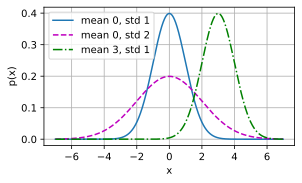

In [10]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)
# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [11]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [12]:
class A:
    def __init__(self):
        self.b = 1
a = A()

In [13]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)
a.do()

Class attribute "b" is 1


In [14]:
class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [15]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))
b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [16]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()
    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

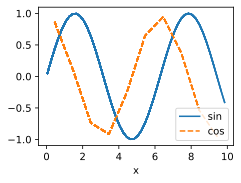

In [17]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [24]:
 class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        raise NotImplementedError

In [30]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self, train):
        raise NotImplementedError
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [34]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        raise NotImplementedError


# 3.3 Code

In [35]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [36]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [37]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [38]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-1.4407,  0.9127]) 
label: tensor([-1.7737])


In [39]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [40]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [41]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [42]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [43]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [44]:
len(data.train_dataloader())

32

# 3.4 Code

In [45]:
 %matplotlib inline
import torch
from d2l import torch as d2l

In [46]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [47]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [48]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [49]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [50]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [53]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [54]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

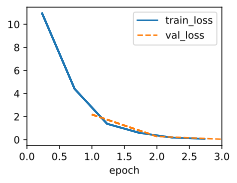

In [55]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [57]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0491, -0.1756], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2086], grad_fn=<RsubBackward1>)


# 3.5 Code

In [58]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [59]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

In [60]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [61]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

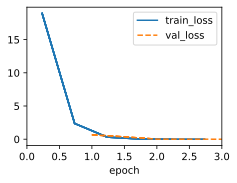

In [62]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
  

In [63]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [64]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([-0.0009, -0.0072])
error in estimating b: tensor([0.0131])


# 3.7 Code

In [65]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [66]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [67]:
def l2_penalty(w):
    return (w ** 2).sum() / 2
 

In [68]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()
    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))
 

In [69]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)
def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.011696268804371357


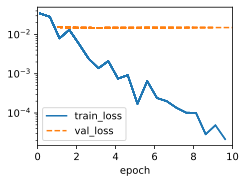

In [70]:
train_scratch(0)

L2 norm of w: 0.0018084095790982246


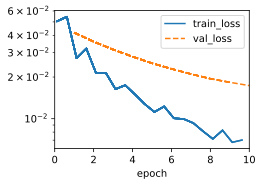

In [71]:
train_scratch(3)

In [72]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.015613192692399025


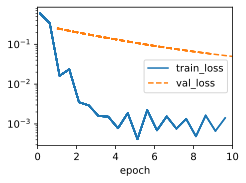

In [73]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))